# Aprendizagem de Máquina no Reconhecimento de Entidades Nomeadas em Ofícios Judiciais

<img src="fluxograma.png" />

# Importações

In [1]:
import json
import pandas as pd
import re
import csv
import random
import numpy as np
from tqdm import tqdm

import spacy
import spacy.cli
import pt_core_news_md
from spacy.lang.pt import Portuguese
from spacy.pipeline import EntityRuler
from spacy.lang.pt.examples import sentences 
from spacy.tokens import DocBin
from spacy.training import offsets_to_biluo_tags

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
spacy.cli.download("pt_core_news_md")

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


In [3]:
nlp = spacy.load("pt_core_news_md")

## Extração das Resoluções do STF

Extraí 50 resoluções aleatoriamente do banco de dados de resoluções do STF. Ajustei o encoding, criei um DataFrame "dfAmostras" e salvei em formato Excel.

In [4]:
def textoJSON(pathJSON):
    #Extrai as Resoluções do JSON fazendo os ajustes necessários e retorna string
    textos = []
    with open(pathJson, 'rb') as f:
        dados = f.readlines()
        for databyte in dados:
            datadecode = databyte.decode(encoding='utf-8')
            datajson = json.loads(datadecode)
            texto = datajson['texto']
            textos.append(texto)
    return(textos)

In [5]:
def salvarJSON(dicionario, caminho):
    #Salva o dicionário em formato JSON no caminho especificado
    tf = open(caminho, "w")
    json.dump(dicionario,tf)
    tf.close()

In [6]:
try:
    #Verifica se já salvei anteriormente a amostra
    pd.read_excel(r'dfAmostras.xlsx')
    print('Já gerado anteriormente')
    
except:
    #Se não tiver salvo:
    pathJson = r'AcordaosRelatorios.json'

    textos = textoJSON(pathJson)
    
    #Crio uma lista aleatória
    aleat = np.random.randint(0,41352,50)
    aleat = aleat.tolist()

    amostras = []
    for item in aleat:
        amostras.append(textos[item])

    #Insiro em um DataFrame
    amostras = pd.DataFrame(amostras)
    
    #Salvo
    amostras.to_excel(r'dfAmostras.xlsx')

Já gerado anteriormente


## Identificação e Classificação das Entidades

A partir do "dfAmostras" procedi com a leitura detalhada e reconhecimento das entidades nomeadas encontradas no corpo das resoluções, guardando na coluna "entidades" delimitadas por aspas duplas e separadas por vírgula. Nomeei o arquivo de dfAmostras_Classif.

In [7]:
dfAmostras_Classif = pd.read_excel(r'dfAmostras_Classif.xlsx')
dfAmostras_Classif

,relatorio,entidades
0,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,"""SENHOR MINISTRO LUIZ FUX"", ""CARLOS GERALDO DE..."
1,O SENHOR MINISTRO MARCO AURÉLIO – À folha 3.68...,"""SENHOR MINISTRO MARCO AURÉLIO"", ""LEI Nº 8.540..."
2,A Senhora Ministra Rosa Weber (Relatora): Trat...,"""Ministra Rosa Weber"", ""Rosmi Romário Reinoso ..."
3,A SENHORA MINISTRA CÁRMEN LÚCIA – (Relatora): ...,"""SENHORA MINISTRA CÁRMEN LÚCIA"", ""Carlos Newto..."
4,O SENHOR MINISTRO EDSON FACHIN (RELATOR): Trat...,"""SENHOR MINISTRO EDSON FACHIN"", ""Min. RICARDO ..."
5,O SENHOR MINISTRO MARCO AURÉLIO – O assessor D...,"""SENHOR MINISTRO MARCO AURÉLIO"", ""Juízo da 1ª ..."
6,O SENHOR MINISTRO LUIZ FUX (RELATOR): Trata-se...,"""SENHOR MINISTRO LUIZ FUX"", ""Partido Humanista..."
7,O SENHOR MINISTRO MARCO AURÉLIO – Por meio da ...,"""SENHOR MINISTRO MARCO AURÉLIO"", ""Ministro Sep..."
8,"2018, neguei seguimento ao extraordinário, ant...","""Supremo"", ""ministro Teori Zavascki"", ""Min. EL..."
9,O SENHOR MINISTRO MARCO AURÉLIO – Em 19 de ago...,"""SENHOR MINISTRO MARCO AURÉLIO"", ""ministro Lui..."


### Extrair lista de entidades com Expressões Regulares

- Importei o dfAmostras_Classif para um DataFrame;

- Separei as entidades extraídas usando Expressões Regulares;

- Criei uma lista com todas as entidades distintas encontradas;

- Salvei com nome dfEnt em Excel para proceder rotulação das entidades.

In [8]:
def extrairListaDaRelacao(relacaoDeEntidades):
    #Extrai do texto as entidades contidas dentro de aspas duplas
    listEnt = []
    t = re.compile(r'"(.*?)"')
    ents = t.finditer(relacaoDeEntidades)
    for ent in ents:
        listEnt.append(ent.group(1).lower())
    return(listEnt)

In [9]:
dfAmostras_Classif['entidades']

0     "SENHOR MINISTRO LUIZ FUX", "CARLOS GERALDO DE...
1     "SENHOR MINISTRO MARCO AURÉLIO", "LEI Nº 8.540...
2     "Ministra Rosa Weber", "Rosmi Romário Reinoso ...
3     "SENHORA MINISTRA CÁRMEN LÚCIA", "Carlos Newto...
4     "SENHOR MINISTRO EDSON FACHIN", "Min. RICARDO ...
5     "SENHOR MINISTRO MARCO AURÉLIO", "Juízo da 1ª ...
6     "SENHOR MINISTRO LUIZ FUX", "Partido Humanista...
7     "SENHOR MINISTRO MARCO AURÉLIO", "Ministro Sep...
8     "Supremo", "ministro Teori Zavascki", "Min. EL...
9     "SENHOR MINISTRO MARCO AURÉLIO", "ministro Lui...
10    "SENHOR MINISTRO RICARDO LEWANDOWSKI", "Súmula...
11    "SENHOR MINISTRO GILMAR MENDES", "súmulas 279 ...
12    "SENHOR MINISTRO MARCO AURÉLIO", "Súmula do Su...
13    "SENHOR MINISTRO MARCO AURÉLIO", "Telmo Correa...
14    "SENHOR MINISTRO MARCO AURÉLIO", "Instituto Na...
15    "SENHOR MINISTRO MARCO AURÉLIO", "Dr. Rafael F...
16    "SENHOR MINISTRO MARCO AURÉLIO", "artigo 39 da...
17    "SENHOR MINISTRO MARCO AURÉLIO", "Tribunal

In [10]:
#Criar texto com todas as entidades distintas do dataframe
listEnt = []
for grupoEntidade in dfAmostras_Classif['entidades']:
    listEnt = listEnt + extrairListaDaRelacao(grupoEntidade)
listEnt = set(listEnt)
print(len(listEnt))
print(listEnt)

516
{'madeiras lontano industria e comercio ltda', 're 576.397-agr, rel. min. cármen lúcia, segunda turma, dje de 21/11/2012', 'ato das disposições constitucionais transitórias da carta de 1988', 'recurso extraordinário nº 150.755-1/pe', 'magistério jurisprudencial da suprema corte', 'art. 1º', 'tribunal de contas do estado do rio grande do sul', 'ministros do supremo tribunal federal', 'suspensão de liminar n. 423/rs', 'emenda constitucional nº 20/98', 'lei de organização do poder judiciário', 'recurso extraordinário nº 855.178/se', 'servidor público', '§ 3º da cf/88', 'artigo 196 da constituição federal', 'art. 2º, aos incisos xxxv, liv e lv do art. 5º, ao caput do art. 37, e ao § 8º do art. 40, todos da magna carta de 1988', 'normas das constituições federal e estadual', 're nº 590.260', 'lopes da costa, moniz de aragão', 'art. 40, § 20, da constituição da república', 'contraminuta de folhas 408 e 409', 'presidente', 'conselho permanente de justiça para o exército', 'art. 54 da lei 

In [11]:
dfEnt = pd.DataFrame(listEnt)
dfEnt.to_excel(r'dfEnt.xlsx')

### Rotulação Manual das Entidades

A partir do dfEnt contendo as entidades distintas, coloquei rótulos manualmente de maneira criteriosa, salvando com nome "dfEnt_Classif". 

In [12]:
dfEnt_Classif = pd.read_excel(r'dfEnt_Classif.xlsx', index_col=0)
dfEnt_Classif

,rotulo
entidade,
advogado-geral da união,AUTORIDADE
auditor federal de controle externo,AUTORIDADE
desembargador,AUTORIDADE
excelentíssimo desembargador josé mário dos martins coelho,AUTORIDADE
juiz da suprema corte de israel,AUTORIDADE
...,...
tribunal de justiça do rio grande do sul,TRIBUNAL
tribunal de justiça dos estados,TRIBUNAL
tribunal de justiça gaúcho,TRIBUNAL


### Verificar se alguma entidade classificada não estão no dfEnt_Classif

Realizei verificação automática para garantir que todas as identificadas foram rotuladas.

In [13]:
#Iterar com os itens da coluna "entidades" do dfAmostras_Classif para listar as entidades
listaDeGruposDeEntidades = []
for entidade in dfAmostras_Classif['entidades']:
    listaDeGruposDeEntidades.append(extrairListaDaRelacao(entidade))
listaDeGruposDeEntidades

[['senhor ministro luiz fux',
  'carlos geraldo de oliveira',
  'previdência social',
  'presidente do tribunal de contas da união',
  'tribunal de contas da união',
  'auditor federal de controle externo',
  'regime próprio de previdência social',
  'rpps',
  'regime geral de previdência social',
  'rgps',
  'btcu',
  'tribunal de contas da união',
  'tcu',
  'stf',
  'constituição da república',
  'ministério público federal',
  'stf',
  'tribunal de contas',
  'art. 96, v, da lei 8.213/91',
  'art. 54 da lei 9.784/99',
  'art. 202, § 2º, da constituição da república',
  'lei 8.213/91',
  'acórdão 663/97',
  'ec 20/1998',
  'lei 9.528/97'],
 ['senhor ministro marco aurélio',
  'lei nº 8.540/92',
  'artigo 1º da lei nº 8.540/92',
  'artigos 12, incisos v e vii, 25, incisos i e ii, e 30, inciso iv, da lei nº 8.212/91',
  'lei nº 9.528/97',
  'recurso extraordinário nº 363.852/mg',
  'josé carlos barbosa moreira',
  'lei nº 8.212/91 - artigo 195, inciso i, da carta federal',
  'emenda c

In [14]:
#Verificar quais entidades não estão na lista de rótulos
for listaDeEntsDoGrupo in listaDeGruposDeEntidades:
    for item in listaDeEntsDoGrupo:
        qt = 0
        try:
            #Tentar localizar a entidade
            dfEnt_Classif.loc[item]
        except:
            #Se não localizar, printa a entidade não localizada e acrescenta na quantidade qt
            print([listaDeGruposDeEntidades.index(listaDeEntsDoGrupo), listaDeEntsDoGrupo.index(item)])
            qt = qt + 1
print(qt)

[12, 9]
0


## Tokenizar e Separar Sentenças das Resoluções com Spacy

Voltando ao "dfAmostras_Classif", a partir da coluna "relatório", tokenizei e dividi os textos em sentenças, guardando na lista "listFrases". Foram obtidas 1072 frases.

In [15]:
#Itera com cada item do dfAmostras_Classif e divide os textos em frases.
listFrases = []
for texto in dfAmostras_Classif['relatorio']:
    frases = nlp(texto.lower())
    for frase in frases.sents:
        listFrases.append(str(frase))
listFrases

['o senhor ministro luiz fux (relator): trata-se de agravo interno em mandado de segurança interposto por carlos geraldo de oliveira em face de decisão monocrática que negou seguimento ao mandamus, assim ementada, in verbis: mandado de segurança.',
 'servidor público.',
 'aposentadoria.',
 'contagem de tempo de atividade rural.',
 'necessidade de comprovação do recolhimento das contribuições previdenciárias para a concessão de aposentadoria pelo regime próprio de previdência social.',
 'alegação de decadência administrativa.',
 'inocorrência.',
 'mandado de segurança a que se nega seguimento.',
 '” originariamente, o writ tem por objetivo desconstituir ato do presidente do tribunal de contas da união que indeferiu o pedido de aposentadoria do agravante “devido a impossibilidade da utilização do tempo rural sem recolhimento das contribuições previdenciárias”.',
 'narra o agravante que é servidor público do tribunal de contas da união desde 27.11.1989, atualmente ocupando o cargo de audi

In [16]:
len(listFrases)

1072

# Entity-Rules

Do dataframe "dfEnt_Classif" contendo as entidades e os rótulos obtidos manualmente:
- Criei uma lista chamada "patterns" no formado a ser importado para o modelo npl2;
- Adicionei o "patterns" no "entity-ruler";
- Para evitar que o spacy aponte outras entidades não planejadas, removi o pipeline NER;
- Salvei o modelo como nlp2_entRules.

In [17]:
#Criação da lista formatada
patterns = []
for i in dfEnt_Classif.iloc:
    pattern = {'label': i.rotulo, 'pattern': i.name}
    patterns.append(pattern)
patterns

[{'label': 'AUTORIDADE', 'pattern': 'advogado-geral da união'},
 {'label': 'AUTORIDADE', 'pattern': 'auditor federal de controle externo'},
 {'label': 'AUTORIDADE', 'pattern': 'desembargador'},
 {'label': 'AUTORIDADE',
  'pattern': 'excelentíssimo desembargador josé mário dos martins coelho'},
 {'label': 'AUTORIDADE', 'pattern': 'juiz da suprema corte de israel'},
 {'label': 'AUTORIDADE', 'pattern': 'juiz de primeiro grau'},
 {'label': 'AUTORIDADE',
  'pattern': 'juíza- auditora da 1ª auditoria da 2ª circunscrição judiciária militar'},
 {'label': 'AUTORIDADE', 'pattern': 'membros do ministério público'},
 {'label': 'AUTORIDADE', 'pattern': 'membros do poder judiciário'},
 {'label': 'AUTORIDADE', 'pattern': 'presidente'},
 {'label': 'AUTORIDADE', 'pattern': 'presidente do supremo tribunal federal'},
 {'label': 'AUTORIDADE', 'pattern': 'presidente do tribunal'},
 {'label': 'AUTORIDADE',
  'pattern': 'presidente do tribunal de contas da união'},
 {'label': 'AUTORIDADE', 'pattern': 'servid

In [18]:
#Inserção no nlp2
nlp2 = spacy.load("pt_core_news_sm")
ruler = nlp2.add_pipe("entity_ruler", before='ner')
ruler.add_patterns(patterns)
ruler.patterns

[{'label': 'AUTORIDADE', 'pattern': 'advogado-geral da união'},
 {'label': 'AUTORIDADE', 'pattern': 'auditor federal de controle externo'},
 {'label': 'AUTORIDADE', 'pattern': 'desembargador'},
 {'label': 'AUTORIDADE',
  'pattern': 'excelentíssimo desembargador josé mário dos martins coelho'},
 {'label': 'AUTORIDADE', 'pattern': 'juiz da suprema corte de israel'},
 {'label': 'AUTORIDADE', 'pattern': 'juiz de primeiro grau'},
 {'label': 'AUTORIDADE',
  'pattern': 'juíza- auditora da 1ª auditoria da 2ª circunscrição judiciária militar'},
 {'label': 'AUTORIDADE', 'pattern': 'membros do ministério público'},
 {'label': 'AUTORIDADE', 'pattern': 'membros do poder judiciário'},
 {'label': 'AUTORIDADE', 'pattern': 'presidente'},
 {'label': 'AUTORIDADE', 'pattern': 'presidente do supremo tribunal federal'},
 {'label': 'AUTORIDADE', 'pattern': 'presidente do tribunal'},
 {'label': 'AUTORIDADE',
  'pattern': 'presidente do tribunal de contas da união'},
 {'label': 'AUTORIDADE', 'pattern': 'servid

In [19]:
#Antes de remover o "ner"
nlp2.pipe_names

['tok2vec',
 'morphologizer',
 'parser',
 'lemmatizer',
 'attribute_ruler',
 'entity_ruler',
 'ner']

Para evitar que o spacy aponte outras entidades não planejadas, removi o pipeline NER

In [20]:
#Após remover o "ner"
nlp2.remove_pipe('ner')
nlp2.pipe_names

['tok2vec',
 'morphologizer',
 'parser',
 'lemmatizer',
 'attribute_ruler',
 'entity_ruler']

## Preparar Bases

Apliquei sobre a lista de Sentenças o modelo Entity-rules para apontar em cada sentença a posição e rótulo de cada entidade.

Montei a lista no formato especificado para treinamento do modelo no Spacy. 

A lista foi nomeada de "baseClassif".

In [21]:
def test_model(text):
    doc = nlp2(text)
    results = []
    entities = []
    for ent in doc.ents:
        entities.append([ent.start_char, ent.end_char, ent.label_])
    results = [str(text), {'entities': entities}]
    return(results)

In [22]:
baseClassif = []
for frase in listFrases:
    token = nlp2(frase)
    base = test_model(token)
    if len(base) > 0:
        baseClassif.append(base)
baseClassif

[['o senhor ministro luiz fux (relator): trata-se de agravo interno em mandado de segurança interposto por carlos geraldo de oliveira em face de decisão monocrática que negou seguimento ao mandamus, assim ementada, in verbis: mandado de segurança.',
  {'entities': [[2, 26, 'JUIZ'], [104, 130, 'PESSOA']]}],
 ['servidor público.', {'entities': [[0, 16, 'AUTORIDADE']]}],
 ['aposentadoria.', {'entities': []}],
 ['contagem de tempo de atividade rural.', {'entities': []}],
 ['necessidade de comprovação do recolhimento das contribuições previdenciárias para a concessão de aposentadoria pelo regime próprio de previdência social.',
  {'entities': [[116, 152, 'ORGANIZACAO']]}],
 ['alegação de decadência administrativa.', {'entities': []}],
 ['inocorrência.', {'entities': []}],
 ['mandado de segurança a que se nega seguimento.', {'entities': []}],
 ['” originariamente, o writ tem por objetivo desconstituir ato do presidente do tribunal de contas da união que indeferiu o pedido de aposentadoria do

In [23]:
len(baseClassif)

1072

## Separação da Base em Treino e Teste

Dividi a lista "baseClassif" utilizando a função train_test_split do Spacy, com 75% das sentenças para treino e 25% para teste. 

Salvei em formato json com respectivos nomes de "TRAIN_DATA" e "test_data" conforme notação padrão e formato utilizado pelo Spacy para treinamento do modelo.

In [24]:
def loadJSON(caminho):
    tf = open(caminho, "r")
    dicionario = json.load(tf)
    tf.close
    return(dicionario)

In [25]:
try:
    #Verifico se já criei anteriormente o TRAIN DATA, para não sobrepor
    loadJSON(r'TRAIN_DATA.json')
    print('Já existe versão')
except:
    #Se não, crio e salvo o TRAIN_DATA e test_data.
    baseSplit = train_test_split(baseClassif)
    TRAIN_DATA = baseSplit[0]
    test_data = baseSplit[1]
    salvarJSON(TRAIN_DATA, r'TRAIN_DATA.json')
    salvarJSON(test_data, r'test_data.json')
    print('TRAIN_DATA e test_data criados')

TRAIN_DATA e test_data criados


In [26]:
def balanco(pathJson):
    textos = []
    with open(pathJson, 'rb') as f:
        dados = f.readlines()
        for databyte in dados:
            datadecode = databyte.decode(encoding='utf-8')
            datajson = json.loads(datadecode)
            textos.append(datajson)
    rotulos=[]
    for i in textos[0]:
        for j in i[1]['entities']:
            rotulos.append(j[2])
    return pd.DataFrame(rotulos).value_counts()

In [27]:
balanco(r'TRAIN_DATA.json')

FUNDAMENTO     330
TRIBUNAL        92
ORGANIZACAO     69
JUIZ            42
AUTORIDADE      36
PESSOA          26
dtype: int64

In [28]:
balanco(r'test_data.json')

FUNDAMENTO     97
TRIBUNAL       37
ORGANIZACAO    19
JUIZ           14
PESSOA         10
AUTORIDADE      7
dtype: int64

## Treinamento do Modelo

### Criando Modelo de Treinamento

A partir do JSON TRAIN_DATA criei o modelo de treinamento "MODEL_TRAIN" utilizando a função "make_doc" do Spacy.

Salvei em disco com nome "MODEL_TRAIN.spacy", conforme padrão do Spacy.

In [29]:
def create_training(TRAIN_DATA):
    db = DocBin()
    for texto, anotacao in tqdm(TRAIN_DATA):
        doc = nlp.make_doc(texto)
        ents = []
        for start, end, label, in anotacao["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print ("Skipping entity", entidade)
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    return (db)

In [30]:
TRAIN_DATA = loadJSON(r'TRAIN_DATA.json')

In [31]:
MODEL_TRAIN = create_training(TRAIN_DATA)

100%|██████████| 804/804 [00:00<00:00, 5161.49it/s]


In [32]:
MODEL_TRAIN.to_disk(r'MODEL_TRAIN.spacy')

### Criando e baixando o CONFIG.CFG

Procedi as seguintes etapas padrão:
- Acessar, configurar e baixar o modelo do site https://spacy.io/usage/training#quickstart

<img src="tela_spacy_config_cfg.png"/>

- Salvar o base_config.cfg na pasta do projeto

- Executar comando para preencher os padrões restantes e converter o base_config em config.cfg (comentar código após gerar)

In [33]:
!python -m spacy init fill-config base_config.cfg config.cfg

[+] Auto-filled config with all values
[+] Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


### Treinando o Modelo 

- Executar comando para treinamento do modelo (comentar código após treinar):

In [34]:
!python -m spacy train config.cfg --output ./output --paths.train ./MODEL_TRAIN.spacy --paths.dev ./MODEL_TRAIN.spacy

[i] Saving to output directory: output
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     67.50    0.27    0.17    0.67    0.00
  1     200        130.48   1793.33   25.96   42.69   18.66    0.26
  2     400        241.56   1371.83   44.18   54.15   37.31    0.44
  3     600         81.48   1007.14   72.85   83.33   64.71    0.73
  6     800         88.10    757.16   81.85   85.12   78.82    0.82
  8    1000        355.84    869.95   90.12   89.02   91.26    0.90
 11    1200        158.70    636.32   92.94   94.14   91.76    0.93
 15    1400        249.89    413.33   86.49   86.93   86.05    0.86
 20    1600        36

[2023-02-06 07:40:22,821] [INFO] Set up nlp object from config
[2023-02-06 07:40:22,837] [INFO] Pipeline: ['tok2vec', 'ner']
[2023-02-06 07:40:22,837] [INFO] Created vocabulary
[2023-02-06 07:40:23,753] [INFO] Added vectors: pt_core_news_md
[2023-02-06 07:40:23,868] [INFO] Finished initializing nlp object
[2023-02-06 07:40:24,627] [INFO] Initialized pipeline components: ['tok2vec', 'ner']


Após o treinamento, fiz upload do melhor modelo treinado na função "nlp".

In [35]:
nlp = spacy.load(r'output/model-best')

## Métricas e Avaliação do Modelo

### Sondagem Visual

Aplicando o modelo em um exemplo do dfAmostras_Classif realizei primeira sondagem visual para verificar por alto se o modelo funcionou.

In [36]:
spacy.displacy.render(nlp(dfAmostras_Classif.loc[14,'relatorio'].lower()), style='ent', jupyter=True)

### Métricas - Criar Vetores

A Avaliação do modelo foi feita utilizando a **Matriz de Confusão** e as **Métricas Acurácia, Precisão, Recall e F1**. 
Para tanto, foi necessário conversão dos dados em vetores, identificando cada token de acordo com o rótulo da entidade a que pertence, sendo que os tokens sem entidades foram rotulados como "O", conforme padrão amplamente utilizado, para em seguida aplicar as funções:
- **create_total_target_vector**: Utilizada para recuperar os dados das entidades do test_data, conforme treinamento MANUAL,  retornando y_true.
- **create_total_prediction_vector**: Utilizada para aplicar o nlp nas sentenças do test_data, conforme MODEL_TRAIN, returnando y_predict.

In [37]:
def get_model_labels(nlp):
    # Lista os rótulos das entidades
    labels = list(nlp.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)
    
def create_total_target_vector(docs):
    #gera uma lista com os rotulos de cada entidade
    target_vector = []
    for doc in docs:
        new = nlp.make_doc(doc[0])
        entities = doc[1]["entities"]
        bilou_entities = offsets_to_biluo_tags(new, entities)
        final = []
        for item in bilou_entities:
            final.append(get_cleaned_label(item))
        target_vector.extend(final)
    return target_vector

def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label

def create_total_prediction_vector(docs: list):
    # Retorna a matriz das entidades previstas
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector
    
def get_all_ner_predictions(text):
    #analisa cada texto recebido e retorna entidades no formato biluo
    doc = nlp(text.lower())
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

def create_prediction_vector(text):
    # itera sobre o dataframe para chamar a função que aplica o nlp em cada texto
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

In [38]:
test_data = loadJSON(r'test_data.json')
test_data

[['8.212/91', {'entities': []}],
 ['3.', {'entities': []}],
 ['isso significa, portanto, nas situações que justificam a providência extraordinária a que se refere o art. 4º da lei nº 8.437/92, que a competência do presidente desta corte representa uma necessária derivação da competência recursal do próprio supremo tribunal federal.',
  {'entities': [[102, 128, 'FUNDAMENTO'],
    [151, 161, 'AUTORIDADE'],
    [245, 269, 'TRIBUNAL']]}],
 ['publiquem.', {'entities': []}],
 ['ademais, a jurisprudência desta corte está orientada no sentido de que a questão relativa à incidência da prescrição está restrita à interpretação da legislação infraconstitucional pertinente e ao exame das provas dos autos, operações vedadas em sede de recurso extraordinário.',
  {'entities': [[150, 180, 'FUNDAMENTO']]}],
 ['no mérito, busca ver declarada a procedência do pedido para reconhecer a competência do supremo para o processamento e julgamento da referida impetração, avocando-se o processo na forma do artigo

In [39]:
rotulos = get_model_labels(nlp)
rotulos

['AUTORIDADE', 'FUNDAMENTO', 'JUIZ', 'O', 'ORGANIZACAO', 'PESSOA', 'TRIBUNAL']

In [40]:
y_true = create_total_target_vector(test_data)
print(y_true)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'O', 'O', 'O', 'O', 'O', 'AUTORIDADE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TRIBUNAL', 'TRIBUNAL', 'TRIBUNAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FUNDAMENTO', 'FUNDAMENTO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TRIBUNAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [41]:
y_pred = create_total_prediction_vector(test_data)
print(y_pred)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'O', 'O', 'O', 'O', 'O', 'AUTORIDADE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TRIBUNAL', 'TRIBUNAL', 'TRIBUNAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FUNDAMENTO', 'FUNDAMENTO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'TRIBUNAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'FUNDAMENTO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [42]:
def salvarCSV(arquivo, destino):   
    with open(destino, 'w') as f:  
        writer = csv.writer(f)
        writer.writerow(arquivo)
    f.close()

In [43]:
salvarCSV(y_true, 'y_true.csv')
salvarCSV(y_pred, 'y_pred.csv')

### Métricas - Matriz de Confusão, Acurácia, Precisão, Recall, F1

Apliquei as métricas aos vetores e salvei os indicadores no "dfMetricas"

In [44]:
def criarDfMetricas(y_true, y_pred):
    cols = ['falsePositive', 'falseNegative', 'truePositive', 'trueNegative']
    df = pd.DataFrame(columns=cols)
    for rotulo in rotulos:
        df.loc[rotulo] = indMetricas(y_true, y_pred, rotulo)
    for col in cols:
        df.loc['TOTAL', col] = df[col].sum()

    listAcuracia = []
    listPrecisao = []
    listRecall = []
    listF1 = []
    for rotulo in df.iloc:
        fp, fn, tp, tn, *_ = rotulo.values
        listAcuracia.append(acuracia(fp, fn, tp, tn))

        precisao_ = precisao(fp, fn, tp, tn)
        listPrecisao.append(precisao_)

        recall_ = recall(fp, fn, tp, tn)
        listRecall.append(recall_)

        listF1.append(f1(precisao_, recall_))

    df['acuracia'] = listAcuracia
    df['precisao'] = listPrecisao
    df['recall'] = listRecall
    df['f1'] = listF1
    return(df)

def indMetricas(y, y_pred, rotulo):
    vec_y_true = vetorRotulos(y, rotulo)
    vec_y_pred = vetorRotulos(y_pred, rotulo)
    i = metricas(vec_y_true, vec_y_pred)
    return i[0], i[1], i[2], i[3]

def metricas(y, y_pred):
    fp = sum([1 for i,j in zip(y, y_pred) if i == 0 and j == 1 ])
    fn = sum([1 for i,j in zip(y, y_pred) if i == 1 and j == 0])
    tp = sum([1 for i,j in zip(y, y_pred) if i == 1 and j == 1 ])
    tn = sum([1 for i,j in zip(y, y_pred) if i == 0 and j == 0])
    return int(fp), int(fn), int(tp), int(tn)

def vetorRotulos(listaEnts, rotulo):
    geral = []
    for ent in listaEnts:
        if ent == rotulo:
            geral.append(1)
        else:
            geral.append(0)
    return(geral)

def acuracia(fp, fn, tp, tn):
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return 0

def precisao(fp, fn, tp, tn):
    try:
        return tp / (tp+fp)
    except:
        return 0

def recall(fp, fn, tp, tn):
    try:
        return tp / (tp+fn)
    except:
        return 0

def f1(precisao, recall):
    try:
        return (2* precisao * recall) / (precisao + recall)
    except:
        return 0


In [45]:
dfMetricas = criarDfMetricas(y_true, y_pred)
dfMetricas

,falsePositive,falseNegative,truePositive,trueNegative,acuracia,precisao,recall,f1
AUTORIDADE,0,3,13,5285,0.999434,1.000000,0.812500,0.896552
FUNDAMENTO,50,98,476,4677,0.972081,0.904943,0.829268,0.865455
JUIZ,0,5,48,5248,0.999057,1.000000,0.905660,0.950495
O,140,58,4374,729,0.962649,0.968985,0.986913,0.977867
ORGANIZACAO,10,32,47,5212,0.992077,0.824561,0.594937,0.691176
PESSOA,8,21,18,5254,0.994529,0.692308,0.461538,0.553846
TRIBUNAL,31,22,86,5162,0.990002,0.735043,0.796296,0.764444
TOTAL,239,239,5062,31567,0.987118,0.954914,0.954914,0.954914


In [46]:
dfMetricas.to_excel('dfMetricas.xlsx')

## Visualização dos Dados

### Matriz de Confusão

In [47]:
def plotar_matriz_confusao(matrizConfusao, classes, normalize=False, cmap=pyplot.cm.Blues):
    title = 'Matriz de Confusão'

    # Computar Matriz de confusão
    if normalize:
        matrizConfusao = matrizConfusao.astype('float') / matrizConfusao.sum(axis=1)[:, np.newaxis]
    
    vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao))
    fig, ax = pyplot.subplots(figsize=(11, 8))
    im = ax.imshow(matrizConfusao, interpolation='nearest', cmap=cmap, norm=vnorm)
    ax.figure.colorbar(im, ax=ax)
    
    # Criar matriz com todos os ticks
    ax.set(xticks=np.arange(matrizConfusao.shape[1]),
           yticks=np.arange(matrizConfusao.shape[0]),
           
           # Rotulos
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Classificações corretas',
           xlabel='Classificações obtidas')

    # Rotacionar e alinhar os rótulos.
    pyplot.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    # Iterar sobre os dados e criar anotações.
    fmt = '.2f' if normalize else 'd'
    thresh = matrizConfusao.max() * 0.1
    for i in range(matrizConfusao.shape[0]):
        for j in range(matrizConfusao.shape[1]):
            ax.text(j, i, format(matrizConfusao[i, j], fmt),
                    ha="center", va="center",
                    color="white" if matrizConfusao[i, j] > thresh else "black")
    fig.tight_layout()
    return pyplot

### Matriz de Confusão - Multiclasse

In [48]:
import warnings
warnings.filterwarnings("ignore")

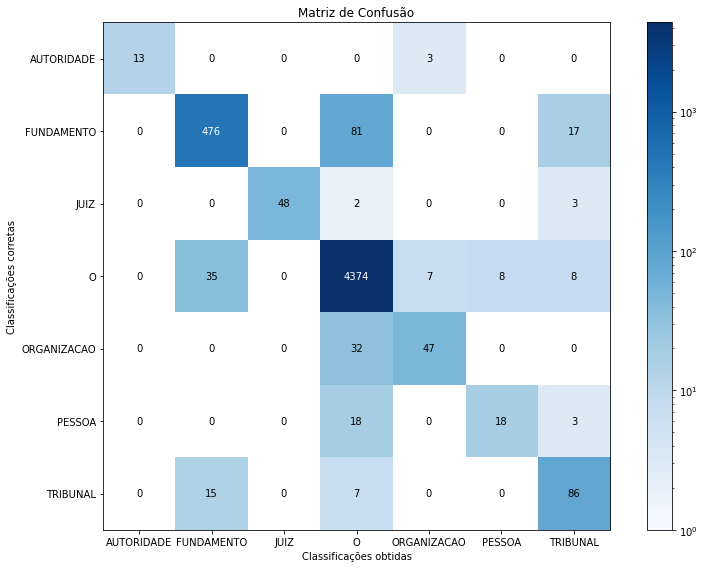

In [49]:
plotar_matriz_confusao(confusion_matrix(y_true, y_pred, rotulos), rotulos, normalize=False, cmap=pyplot.cm.Blues)
plt.savefig('matrizConfusaoMulticlasse');

In [50]:
dfMetricas = pd.read_excel(r'dfMetricas.xlsx', index_col = 0)

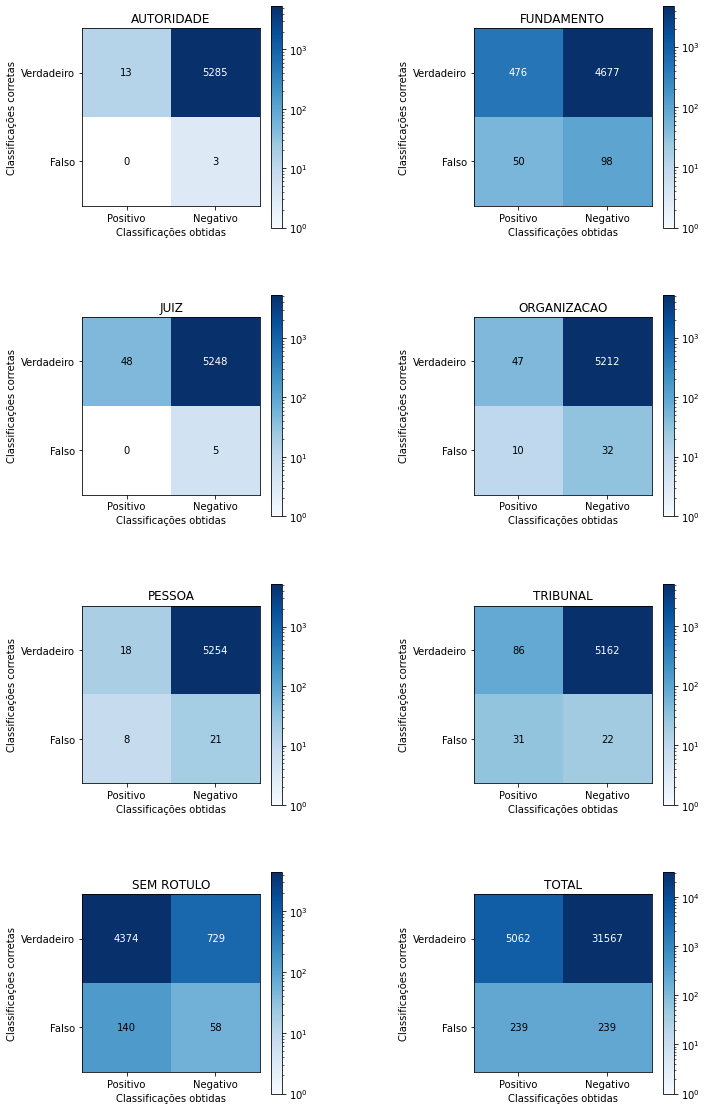

In [51]:
#Exibe o gráfico
gridsize = (19, 8)
fig = plt.figure(figsize=(11, 20))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=3, rowspan=4)
ax2 = plt.subplot2grid(gridsize, (0, 5), colspan=3, rowspan=4)
ax3 = plt.subplot2grid(gridsize, (5, 0), colspan=3, rowspan=4)
ax4 = plt.subplot2grid(gridsize, (5, 5), colspan=3, rowspan=4)
ax5 = plt.subplot2grid(gridsize, (10, 0), colspan=3, rowspan=4)
ax6 = plt.subplot2grid(gridsize, (10, 5), colspan=3, rowspan=4)
ax7 = plt.subplot2grid(gridsize, (15, 0), colspan=3, rowspan=4)
ax8 = plt.subplot2grid(gridsize, (15, 5), colspan=3, rowspan=4)

rotulosX = 'Classificações obtidas'
rotulosY = 'Classificações corretas'
rotulosTicksX = ['Positivo', 'Negativo']
rotulosTicksY = ['Verdadeiro', 'Falso']
mudacor = 300
cmap = pyplot.cm.Blues

#--------------- ax 1 -----------------

matrizConfusao_1 = [[dfMetricas.loc['AUTORIDADE', 'truePositive'], dfMetricas.loc['AUTORIDADE', 'trueNegative']], 
                    [dfMetricas.loc['AUTORIDADE', 'falsePositive'], dfMetricas.loc['AUTORIDADE', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_1))
im = ax1.imshow(matrizConfusao_1, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax1.figure.colorbar(im, ax=ax1)

# Seta os rótulos no gráfico
ax1.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'AUTORIDADE',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax1.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_1)):
    for j in range(len(matrizConfusao_1[i])):
        ax1.text(j, i, matrizConfusao_1[i][j], ha="center", va="center", color="white" 
                if matrizConfusao_1[i][j] > mudacor else "black")

#--------------- ax 2 -----------------

matrizConfusao_2 = [[dfMetricas.loc['FUNDAMENTO', 'truePositive'], dfMetricas.loc['FUNDAMENTO', 'trueNegative']], 
                    [dfMetricas.loc['FUNDAMENTO', 'falsePositive'], dfMetricas.loc['FUNDAMENTO', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_2))
im = ax2.imshow(matrizConfusao_2, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax2.figure.colorbar(im, ax=ax2)

# Seta os rótulos no gráfico
ax2.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'FUNDAMENTO',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax2.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_2)):
    for j in range(len(matrizConfusao_2[i])):
        ax2.text(j, i, matrizConfusao_2[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_2[i][j] > mudacor else "black")


#--------------- ax 3 -----------------
        

matrizConfusao_3 = [[dfMetricas.loc['JUIZ', 'truePositive'], dfMetricas.loc['JUIZ', 'trueNegative']], 
                    [dfMetricas.loc['JUIZ', 'falsePositive'], dfMetricas.loc['JUIZ', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_3))
im = ax3.imshow(matrizConfusao_3, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax3.figure.colorbar(im, ax=ax3)

# Seta os rótulos no gráfico
ax3.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'JUIZ',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax3.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_3)):
    for j in range(len(matrizConfusao_3[i])):
        ax3.text(j, i, matrizConfusao_3[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_3[i][j] > mudacor else "black")
        
#--------------- ax 4 -----------------

matrizConfusao_4 = [[dfMetricas.loc['ORGANIZACAO', 'truePositive'], dfMetricas.loc['ORGANIZACAO', 'trueNegative']], 
                    [dfMetricas.loc['ORGANIZACAO', 'falsePositive'], dfMetricas.loc['ORGANIZACAO', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_4))
im = ax4.imshow(matrizConfusao_4, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax4.figure.colorbar(im, ax=ax4)

# Seta os rótulos no gráfico
ax4.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'ORGANIZACAO',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax4.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_4)):
    for j in range(len(matrizConfusao_4[i])):
        ax4.text(j, i, matrizConfusao_4[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_4[i][j] > mudacor else "black")
        
#--------------- ax 5 -----------------

matrizConfusao_5 = [[dfMetricas.loc['PESSOA', 'truePositive'], dfMetricas.loc['PESSOA', 'trueNegative']], 
                    [dfMetricas.loc['PESSOA', 'falsePositive'], dfMetricas.loc['PESSOA', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_5))
im = ax5.imshow(matrizConfusao_5, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax5.figure.colorbar(im, ax=ax5)

# Seta os rótulos no gráfico
ax5.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'PESSOA',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax5.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_5)):
    for j in range(len(matrizConfusao_5[i])):
        ax5.text(j, i, matrizConfusao_5[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_5[i][j] > mudacor else "black")     
    
    #--------------- ax 6 -----------------

matrizConfusao_6 = [[dfMetricas.loc['TRIBUNAL', 'truePositive'], dfMetricas.loc['TRIBUNAL', 'trueNegative']], 
                    [dfMetricas.loc['TRIBUNAL', 'falsePositive'], dfMetricas.loc['TRIBUNAL', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_6))
im = ax6.imshow(matrizConfusao_6, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax6.figure.colorbar(im, ax=ax6)

# Seta os rótulos no gráfico
ax6.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'TRIBUNAL',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax6.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_6)):
    for j in range(len(matrizConfusao_6[i])):
        ax6.text(j, i, matrizConfusao_6[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_6[i][j] > mudacor else "black")
        
        
    #--------------- ax 7 -----------------

matrizConfusao_7 = [[dfMetricas.loc['O', 'truePositive'], dfMetricas.loc['O', 'trueNegative']], 
                    [dfMetricas.loc['O', 'falsePositive'], dfMetricas.loc['O', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_7))
im = ax7.imshow(matrizConfusao_7, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax7.figure.colorbar(im, ax=ax7)

# Seta os rótulos no gráfico
ax7.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'SEM ROTULO',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax7.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_7)):
    for j in range(len(matrizConfusao_7[i])):
        ax7.text(j, i, matrizConfusao_7[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_7[i][j] > mudacor else "black")
        
    #--------------- ax 8 -----------------

matrizConfusao_8 = [[dfMetricas.loc['TOTAL', 'truePositive'], dfMetricas.loc['TOTAL', 'trueNegative']], 
                    [dfMetricas.loc['TOTAL', 'falsePositive'], dfMetricas.loc['TOTAL', 'falseNegative']]]

# Escolhe o estilo
vnorm = colors.LogNorm(vmin=1, vmax=np.max(matrizConfusao_8))
im = ax8.imshow(matrizConfusao_8, cmap=cmap, norm=vnorm)

#Exibe a barra de cores
ax8.figure.colorbar(im, ax=ax8)

# Seta os rótulos no gráfico
ax8.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'TOTAL',
       ylabel=rotulosY,
       xlabel=rotulosX)

plt.setp(ax8.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

for i in range(len(matrizConfusao_8)):
    for j in range(len(matrizConfusao_8[i])):
        ax8.text(j, i, matrizConfusao_8[i][j], ha="center", va="center", color="white" 
                 if matrizConfusao_8[i][j] > 1700 else "black")

plt.savefig('matrizConfusao')

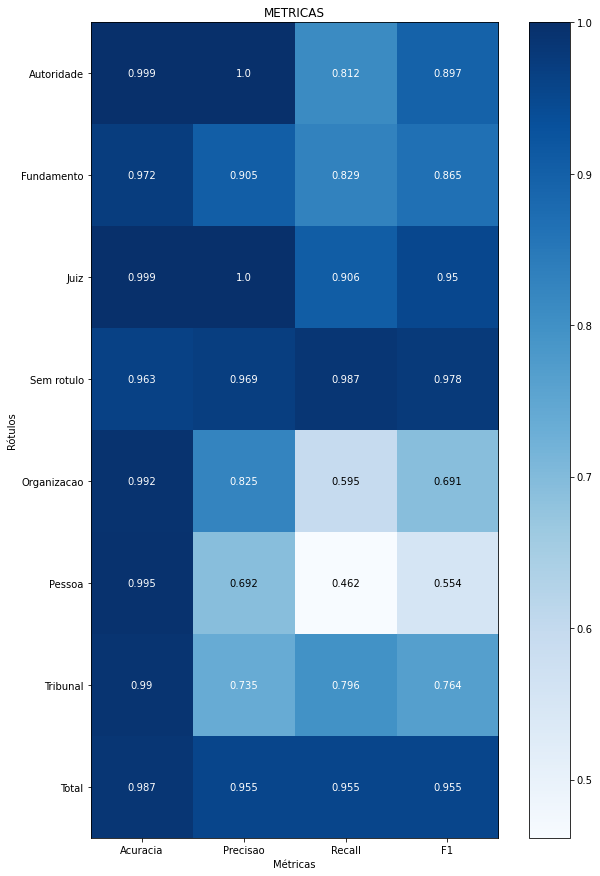

In [52]:
#Dados
matrizMetricas = dfMetricas[['acuracia','precisao','recall','f1']].rename(index={"O":"SEM ROTULO"})

#Exibe o gráfico
mudacor = (min(matrizMetricas.min()) + max(matrizMetricas.max()))/2
gridsize = (1, 1)
fig = plt.figure(figsize=(11, 15))
ax = plt.subplot2grid(gridsize, (0, 0))

rotulosX = 'Métricas'
rotulosY = 'Rótulos'
rotulosTicksX = list(map(str.capitalize, matrizMetricas.columns))
rotulosTicksY = list(map(str.capitalize, matrizMetricas.index))
cmap = pyplot.cm.Blues

# Escolhe o estilo
im = ax.imshow(matrizMetricas, cmap=cmap)

#Exibe a barra de cores
ax.figure.colorbar(im, ax=ax)

# Seta os rótulos no gráfico
ax.set(xticks=np.arange(len(rotulosTicksX)),
       yticks=np.arange(len(rotulosTicksY)),
       xticklabels=rotulosTicksX, yticklabels=rotulosTicksY,
       title = 'METRICAS',
       ylabel=rotulosY,
       xlabel=rotulosX)

#Ajusta os rótulos
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

#Insere os valores
for i in range(len(matrizMetricas.index)):
    for j in range(len(matrizMetricas.columns)):
        ax.text(j, i, round(matrizMetricas.iloc[i, j],3), ha="center", va="center", color="white" 
                if matrizMetricas.iloc[i, j] > mudacor else "black")

plt.savefig('metricas')